<a href="https://colab.research.google.com/github/xkumachii/pneumonia/blob/main/Pneumonia_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Diagnosing Pneumonia with Keras CNNs
### By Marc Alejandro, Rosario Araujo, and Daniel Wadell

In [1]:
import numpy as np

import os

import tensorflow as tf
from tensorflow.keras import Model, Input, models, layers
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2

In [2]:
! pip install -q kaggle
from google.colab import files

In [3]:
# 1.) check your kaggle account 
# 2.) go to edit profile
# 3.) create a new api token
# 4.) upload your kaggle.json file here
# 5.) for any retesting, keep your json file, and do not regenerate your api token unless absolutely needed
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kumachii","key":"f54f1492a39626e5e7bc3b112a34c56b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:41<00:00, 40.2MB/s]
100% 2.29G/2.29G [00:41<00:00, 59.3MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile("chest-xray-pneumonia.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

# Summary of Our Data Set and What We Will Do.

This notebook will demonstrate the diagnosis of pneumonia, and different types of pneumonia using various kinds of Convolutional Neural Networks. We will be using our own simple CNN to start off each section. Afterwards, we will be using VGG16, and Xception, and freezing various layers in order to test their classifying efficacy. 

The dataset we are working with is of various X-ray images of Chinese pediatric patients' lungs, sourced from Kaggle. There is a significant imbalance in our training data set, so we will be using various balancing techniques, like weighting and oversampling.

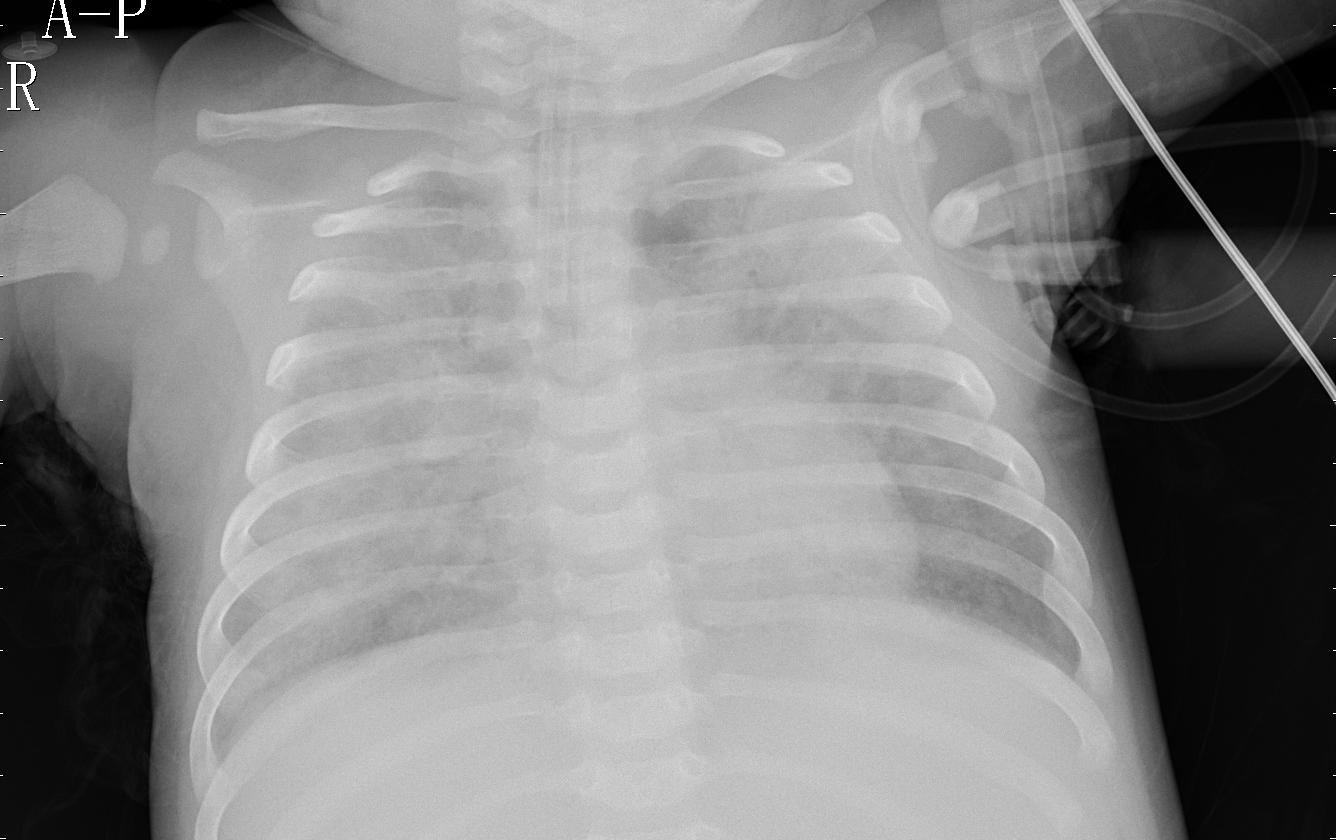

In [6]:
img_path = "/content/files/chest_xray/train/PNEUMONIA/person1945_bacteria_4872.jpeg"

display(Image(img_path))

# Binary Classification

We will first do binary classification, experimenting on different types of CNNs -- a simple CNN, the same simple CNN with a few frozen layers, VGG16, and XCeption.

## Loading our data

In [7]:
def load_data(path, color_mode, size):

  imgs = []
  labels = np.array([])
  filenames = np.array([])

  for dir in ["NORMAL", "PNEUMONIA"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      img = image.load_img(temp_path + "/" + f, color_mode=color_mode, target_size=size)
      x = image.img_to_array(img)
      imgs.append(x)
      labels = np.append(labels, [int(dir == 'PNEUMONIA')])

      filenames = np.append(filenames, temp_path + "/" + f)

      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels, filenames

In [8]:
X_train, y_train, train_files = load_data("/content/files/chest_xray/train", "grayscale", (300, 300))
X_test, y_test, test_files = load_data("/content/files/chest_xray/test", "grayscale", (300, 300))

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 300, 300, 1)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 300, 300, 1)


##Simple CNN

We first start off with a simple CNN, with a Dropout rate of 0.5.

In [9]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

### training

To take care of potential imbalances within our data, we weight sdfsdfsdf

To further take care of the invariant nature of the data, we have a data generator.

In [10]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {0:class_weight[0], 1:class_weight[1]}

batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)

history = model.fit(gen_data,steps_per_epoch=len(gen_data),epochs=20,callbacks=callback,validation_data=gen_test,validation_steps=len(gen_test),class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 40s 216ms/step - loss: 0.8040 - accuracy: 0.5499 - val_loss: 0.5532 - val_accuracy: 0.7452
Epoch 2/20
163/163 [==============================] - 35s 213ms/step - loss: 0.4976 - accuracy: 0.7537 - val_loss: 0.4396 - val_accuracy: 0.7853
Epoch 3/20
163/163 [==============================] - 35s 212ms/step - loss: 0.4388 - accuracy: 0.8085 - val_loss: 0.3685 - val_accuracy: 0.8494
Epoch 4/20
163/163 [==============================] - 35s 212ms/step - loss: 0.4110 - accuracy: 0.8308 - val_loss: 0.3512 - val_accuracy: 0.8526
Epoch 5/20
163/163 [==============================] - 35s 215ms/step - loss: 0.3740 - accuracy: 0.8437 - val_loss: 0.3992 - val_accuracy: 0.8269
Epoch 6/20
163/163 [==============================] - 34s 210ms/step - loss: 0.3501 - accuracy: 0.8554 - val_loss: 0.3661 - val_accuracy: 0.8622


### diagnostics

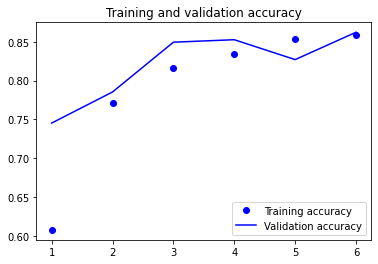

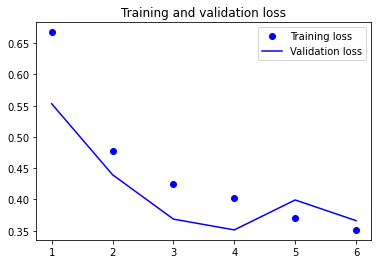

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
np.random.seed(42)

normal_indices = np.array([i == 0 for i in y_test])
pneumonia_indices = np.array([i == 1 for i in y_test])

test_normal_files = test_files[normal_indices]
test_pneumonia_files = test_files[pneumonia_indices]

test_normal_sample_indices = np.random.choice(test_normal_files.shape[0], 25)
test_normal_sample_files = test_normal_files[test_normal_sample_indices]

test_pneumonia_sample_indices = np.random.choice(test_pneumonia_files.shape[0], 25)
test_pneumonia_sample_files = test_pneumonia_files[test_pneumonia_sample_indices]

In [13]:
normal_preds_array = np.array([])
normal_rounded = np.array([])

for i in test_normal_files :
  img_path = i

  img = image.load_img(img_path, color_mode="grayscale", target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  normal_preds_array = np.append(normal_preds_array, preds)
  normal_rounded = np.append(normal_rounded, round(preds))

In [14]:
pneumonia_preds_array = np.array([])
pneumonia_rounded = np.array([])

for i in test_pneumonia_files:
  img_path = i

  img = image.load_img(img_path, color_mode="grayscale", target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  pneumonia_preds_array = np.append(pneumonia_preds_array, preds)
  pneumonia_rounded = np.append(pneumonia_rounded, round(preds))

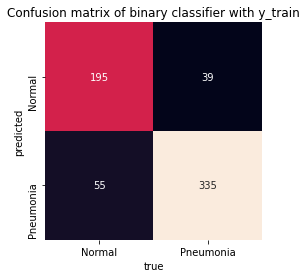

In [15]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

combined = np.array([])
combined = np.append(np.zeros(normal_rounded.shape), np.ones(pneumonia_rounded.shape))



preds = np.array([])
preds = np.append(normal_rounded, pneumonia_rounded)


mat = confusion_matrix(preds, combined)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])

plt.title('Confusion matrix of binary classifier with y_train')
plt.xlabel('true')
plt.ylabel('predicted');

## Simple CNN, with Frozen Layers

In [16]:
np.random.seed(42)
tf.random.set_seed(42)


K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1),trainable=False))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))


model.add(layers.Conv2D(64, (3, 3), activation='relu',trainable=False))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        1

### training

In [17]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {0:class_weight[0], 1:class_weight[1]}

batch_size = 32

traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train, y_train, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)

history = model.fit(gen_data,steps_per_epoch=len(gen_data),epochs=20,callbacks=callback,validation_data=gen_test,validation_steps=len(gen_test),class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 35s 212ms/step - loss: 0.6586 - accuracy: 0.6322 - val_loss: 0.5424 - val_accuracy: 0.7099
Epoch 2/20
163/163 [==============================] - 34s 208ms/step - loss: 0.4927 - accuracy: 0.7697 - val_loss: 0.4624 - val_accuracy: 0.7772
Epoch 3/20
163/163 [==============================] - 35s 212ms/step - loss: 0.4367 - accuracy: 0.8140 - val_loss: 0.4248 - val_accuracy: 0.8125
Epoch 4/20
163/163 [==============================] - 34s 210ms/step - loss: 0.4222 - accuracy: 0.8227 - val_loss: 0.4243 - val_accuracy: 0.8189
Epoch 5/20
163/163 [==============================] - 34s 207ms/step - loss: 0.4039 - accuracy: 0.8371 - val_loss: 0.9803 - val_accuracy: 0.4311


### diagnostics

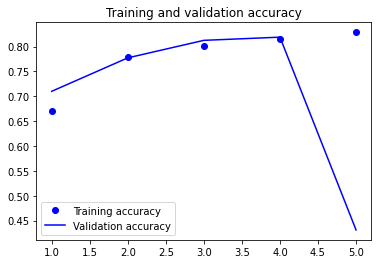

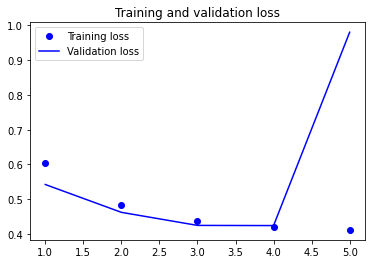

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
normal_preds_array = np.array([])
normal_rounded = np.array([])

for i in test_normal_files :
  img_path = i

  img = image.load_img(img_path, color_mode="grayscale", target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  normal_preds_array = np.append(normal_preds_array, preds)
  normal_rounded = np.append(normal_rounded, round(preds))

In [20]:
pneumonia_preds_array = np.array([])
pneumonia_rounded = np.array([])

for i in test_pneumonia_files:
  img_path = i

  img = image.load_img(img_path, color_mode="grayscale", target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  pneumonia_preds_array = np.append(pneumonia_preds_array, preds)
  pneumonia_rounded = np.append(pneumonia_rounded, round(preds))

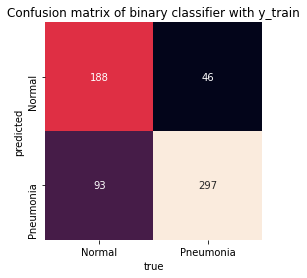

In [21]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

combined = np.array([])
combined = np.append(np.zeros(normal_rounded.shape), np.ones(pneumonia_rounded.shape))



preds = np.array([])
preds = np.append(normal_rounded, pneumonia_rounded)


mat = confusion_matrix(preds, combined)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])

plt.title('Confusion matrix of binary classifier with y_train')
plt.xlabel('true')
plt.ylabel('predicted');

## XCeption Transfer Learning

In [22]:
X_train, y_train, train_files = load_data("/content/files/chest_xray/train", "rgb", (150, 150))
X_test, y_test, test_files = load_data("/content/files/chest_xray/test", "rgb", (150, 150))

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)


In [23]:
from glob import glob

np.random.seed(42)
tf.random.set_seed(42)

train_path = "/content/files/chest_xray/train"
test_path = "/content/files/chest_xray/test"


base_model = Xception(weights='imagenet',input_shape=(150, 150, 3),include_top=False)


base_model.trainable = False

folders = glob('/content/files/chest_xray/train/*')

x = Flatten()(base_model.output)

#add the number of classes we have to 
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=prediction)

model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
_____________________________

### training

In [24]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {0:class_weight[0], 1:class_weight[1]}


train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow(X_train, y_train, batch_size = 32)

test_set = test_datagen.flow(X_test, y_test, batch_size = 32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)

In [25]:
history = model.fit(training_set,steps_per_epoch=len(training_set),epochs=20,callbacks=callback,validation_data=test_set,validation_steps=len(test_set),class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 30s 170ms/step - loss: 1.6369 - accuracy: 0.8110 - val_loss: 1.0102 - val_accuracy: 0.8638
Epoch 2/20
163/163 [==============================] - 27s 165ms/step - loss: 0.5809 - accuracy: 0.9114 - val_loss: 1.3340 - val_accuracy: 0.8429
Epoch 3/20
163/163 [==============================] - 27s 165ms/step - loss: 0.5420 - accuracy: 0.9275 - val_loss: 1.0843 - val_accuracy: 0.8750
Epoch 4/20
163/163 [==============================] - 27s 165ms/step - loss: 0.5455 - accuracy: 0.9305 - val_loss: 1.1987 - val_accuracy: 0.8670


###diagnostics

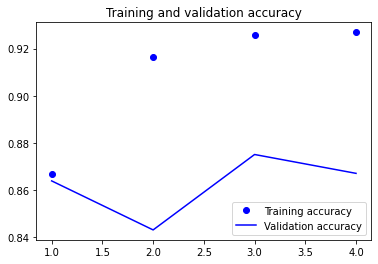

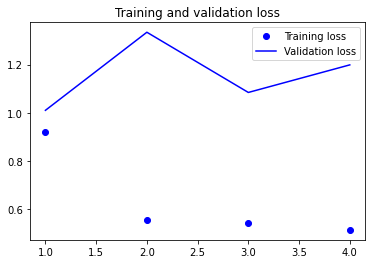

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
normal_preds_array = np.array([])
normal_rounded = np.array([])

for i in test_normal_files :
  img_path = i

  img = image.load_img(img_path, target_size=(150,150))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  normal_preds_array = np.append(normal_preds_array, preds)
  normal_rounded = np.append(normal_rounded, round(preds))

In [28]:
pneumonia_preds_array = np.array([])
pneumonia_rounded = np.array([])

for i in test_pneumonia_files:
  img_path = i

  img = image.load_img(img_path, target_size=(150,150))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  pneumonia_preds_array = np.append(pneumonia_preds_array, preds)
  pneumonia_rounded = np.append(pneumonia_rounded, round(preds))

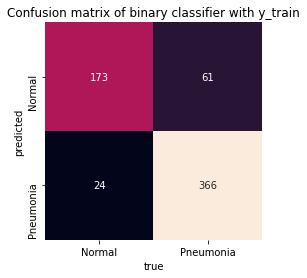

In [29]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

combined = np.array([])
combined = np.append(np.zeros(normal_rounded.shape), np.ones(pneumonia_rounded.shape))



preds = np.array([])
preds = np.append(normal_rounded, pneumonia_rounded)


mat = confusion_matrix(preds, combined)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])

plt.title('Confusion matrix of binary classifier with y_train')
plt.xlabel('true')
plt.ylabel('predicted');

## VGG16 Transfer Learning

In [30]:
X_train, y_train, train_files = load_data("/content/files/chest_xray/train", "rgb", (224, 224))
X_test, y_test, test_files = load_data("/content/files/chest_xray/test", "rgb", (224, 224))

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 3000
Files loaded for /content/files/chest_xray/train: 3500
(5216, 224, 224, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 224, 224, 3)


In [31]:
K.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

img_size = [224,224]

train_path = "/content/files/chest_xray/train"
test_path = "/content/files/chest_xray/test"


vgg = VGG16(input_shape=img_size + [3], weights='imagenet', include_top=False)

vgg.trainable = False

folders = glob('/content/files/chest_xray/train/*')

x = Flatten()(vgg.output)

prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

### training

In [32]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = {0:class_weight[0], 1:class_weight[1]}


train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow(X_train, y_train, batch_size = 32)

test_set = test_datagen.flow(X_test, y_test, batch_size = 32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)



In [33]:
history = model.fit(training_set,steps_per_epoch=len(training_set),epochs=20,callbacks=callback,validation_data=test_set,validation_steps=len(test_set), class_weight=class_weights)

Epoch 1/20
163/163 [==============================] - 58s 347ms/step - loss: 0.5131 - accuracy: 0.8176 - val_loss: 0.3548 - val_accuracy: 0.8478
Epoch 2/20
163/163 [==============================] - 55s 338ms/step - loss: 0.1751 - accuracy: 0.9259 - val_loss: 0.2677 - val_accuracy: 0.9054
Epoch 3/20
163/163 [==============================] - 54s 334ms/step - loss: 0.1526 - accuracy: 0.9427 - val_loss: 0.6044 - val_accuracy: 0.7708
Epoch 4/20
163/163 [==============================] - 55s 337ms/step - loss: 0.1229 - accuracy: 0.9466 - val_loss: 0.3814 - val_accuracy: 0.8654
Epoch 5/20
163/163 [==============================] - 56s 346ms/step - loss: 0.1257 - accuracy: 0.9488 - val_loss: 0.3178 - val_accuracy: 0.9071


###diagnostics

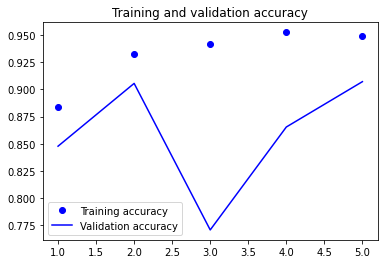

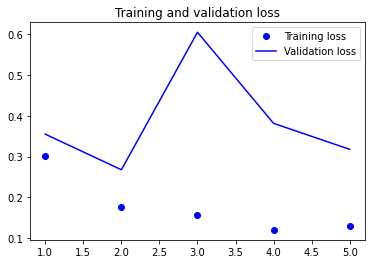

In [34]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
normal_preds_array = np.array([])
normal_rounded = np.array([])

for i in test_normal_files :
  img_path = i

  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  normal_preds_array = np.append(normal_preds_array, preds)
  normal_rounded = np.append(normal_rounded, round(preds))

In [36]:
pneumonia_preds_array = np.array([])
pneumonia_rounded = np.array([])

for i in test_pneumonia_files:
  img_path = i

  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  preds = model.predict(img)[0][0]
  pneumonia_preds_array = np.append(pneumonia_preds_array, preds)
  pneumonia_rounded = np.append(pneumonia_rounded, round(preds))


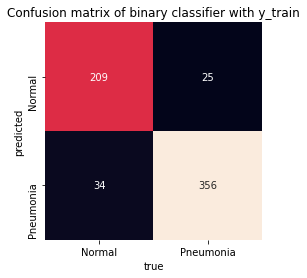

In [37]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

combined = np.array([])
combined = np.append(np.zeros(normal_rounded.shape), np.ones(pneumonia_rounded.shape))



preds = np.array([])
preds = np.append(normal_rounded, pneumonia_rounded)


mat = confusion_matrix(preds, combined)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])

plt.title('Confusion matrix of binary classifier with y_test')
plt.xlabel('true')
plt.ylabel('predicted');

## heatmaps, for our VGG16 Model

Since VGG16 yields a satisfactory validation accuracy, along with providing us a reasonable size for a reasonably detailed heatmap, we decided to go with that model for that purpose

In [38]:
np.random.seed(42)

normal_indices = np.array([i == 0 for i in y_test])
pneumonia_indices = np.array([i == 1 for i in y_test])

test_normal_files = test_files[normal_indices]
test_pneumonia_files = test_files[pneumonia_indices]

test_normal_sample_indices = np.random.choice(test_normal_files.shape[0], 25)
test_normal_sample_files = test_normal_files[test_normal_sample_indices]

test_pneumonia_sample_indices = np.random.choice(test_pneumonia_files.shape[0], 25)
test_pneumonia_sample_files = test_pneumonia_files[test_pneumonia_sample_indices]

In [39]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array /= 255
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def heatgrid(heatmaps, preds_array, title):
  f, axarr = plt.subplots(5,5,figsize=(17, 17))
  f.suptitle(title)
  # row 1
  axarr[0,0].imshow(heatmaps[0])
  axarr[0,0].set_title("{:.0%}".format(preds_array[0]))
  axarr[0,1].imshow(heatmaps[1])
  axarr[0,1].set_title("{:.0%}".format(preds_array[1]))
  axarr[0,2].imshow(heatmaps[2])
  axarr[0,2].set_title("{:.0%}".format(preds_array[2]))
  axarr[0,3].imshow(heatmaps[3])
  axarr[0,3].set_title("{:.0%}".format(preds_array[3]))
  axarr[0,4].imshow(heatmaps[4])
  axarr[0,4].set_title("{:.0%}".format(preds_array[4]))

  # row 2
  axarr[1,0].imshow(heatmaps[5])
  axarr[1,0].set_title("{:.0%}".format(preds_array[5]))
  axarr[1,1].imshow(heatmaps[6])
  axarr[1,1].set_title("{:.0%}".format(preds_array[6]))
  axarr[1,2].imshow(heatmaps[7])
  axarr[1,2].set_title("{:.0%}".format(preds_array[7]))
  axarr[1,3].imshow(heatmaps[8])
  axarr[1,3].set_title("{:.0%}".format(preds_array[8]))
  axarr[1,4].imshow(heatmaps[9])
  axarr[1,4].set_title("{:.0%}".format(preds_array[9]))

  # row 3
  axarr[2,0].imshow(heatmaps[10])
  axarr[2,0].set_title("{:.0%}".format(preds_array[10]))
  axarr[2,1].imshow(heatmaps[11])
  axarr[2,1].set_title("{:.0%}".format(preds_array[11]))
  axarr[2,2].imshow(heatmaps[12])
  axarr[2,2].set_title("{:.0%}".format(preds_array[12]))
  axarr[2,3].imshow(heatmaps[13])
  axarr[2,3].set_title("{:.0%}".format(preds_array[13]))
  axarr[2,4].imshow(heatmaps[14])
  axarr[2,4].set_title("{:.0%}".format(preds_array[14]))

  # row 4
  axarr[3,0].imshow(heatmaps[15])
  axarr[3,0].set_title("{:.0%}".format(preds_array[15]))
  axarr[3,1].imshow(heatmaps[16])
  axarr[3,1].set_title("{:.0%}".format(preds_array[16]))
  axarr[3,2].imshow(heatmaps[17])
  axarr[3,2].set_title("{:.0%}".format(preds_array[17]))
  axarr[3,3].imshow(heatmaps[18])
  axarr[3,3].set_title("{:.0%}".format(preds_array[18]))
  axarr[3,4].imshow(heatmaps[19])
  axarr[3,4].set_title("{:.0%}".format(preds_array[19]))

  # row 5
  axarr[4,0].imshow(heatmaps[20])
  axarr[4,0].set_title("{:.0%}".format(preds_array[20]))
  axarr[4,1].imshow(heatmaps[21])
  axarr[4,1].set_title("{:.0%}".format(preds_array[21]))
  axarr[4,2].imshow(heatmaps[22])
  axarr[4,2].set_title("{:.0%}".format(preds_array[22]))
  axarr[4,3].imshow(heatmaps[23])
  axarr[4,3].set_title("{:.0%}".format(preds_array[23]))
  axarr[4,4].imshow(heatmaps[24])
  axarr[4,4].set_title("{:.0%}".format(preds_array[24]));


def superimposition(img_path, heatmap):
  # We load the original image
  img = image.load_img(img_path)
  img = image.img_to_array(img)

  # We rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # We use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # We create an image with RGB colorized heatmap
  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * 0.4 + img
  superimposed_img = image.array_to_img(superimposed_img)

  # Save the superimposed image
  save_path = "xray_superimposed.jpg"
  superimposed_img.save(save_path)

  # Display Grad CAM
  display(Image(save_path))

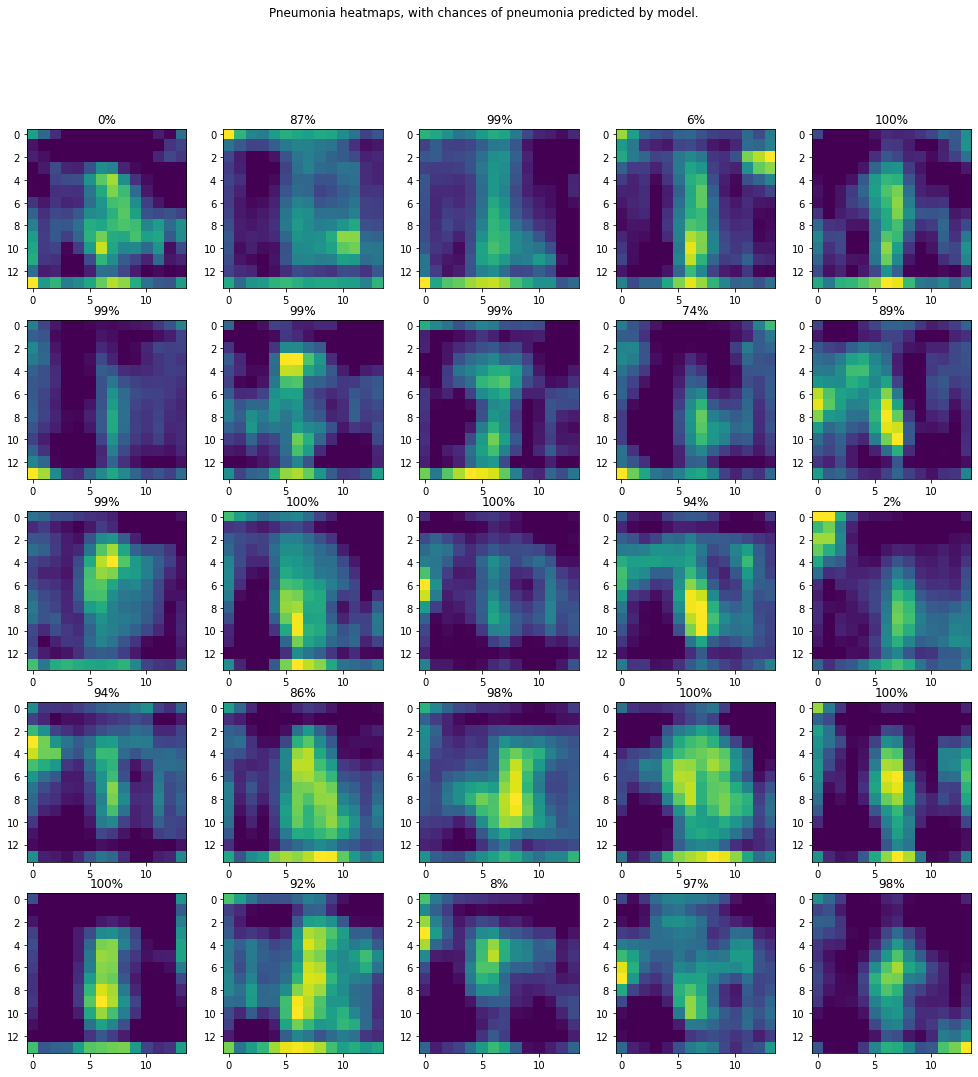

In [40]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool", "flatten", "dense"
]

heatmaps = []

for i in test_pneumonia_sample_files:
  img_path = i
  img_array = get_img_array(img_path, size=(224,224))

  heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)
  heatmaps.append(heatmap)

heatgrid(heatmaps, pneumonia_preds_array, "Pneumonia heatmaps, with chances of pneumonia predicted by model.")

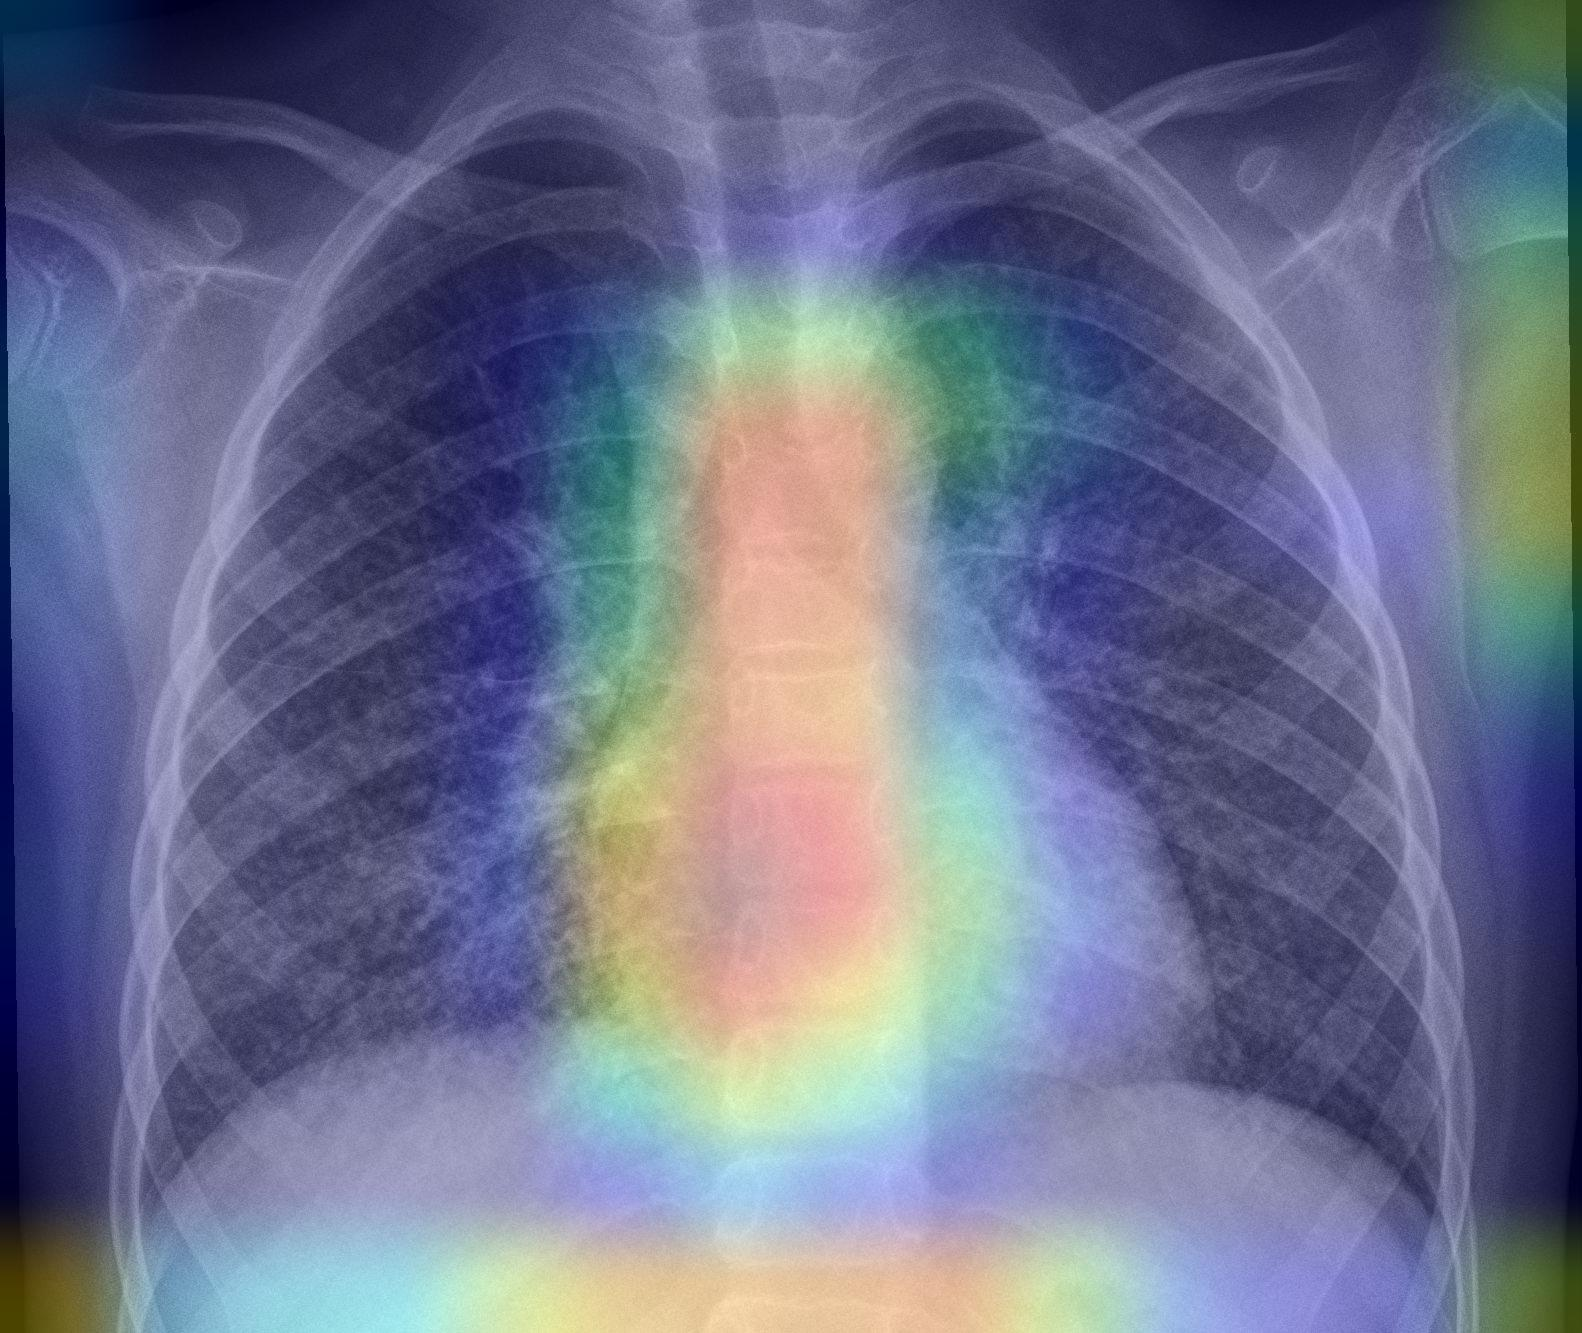

0.9989107847213745


In [41]:
superimposition(test_pneumonia_sample_files[20], heatmaps[20])
print(pneumonia_preds_array[20])

We can see that the more certainly our model predicts a pneumonia case, the more it tends to focus on the lungs.

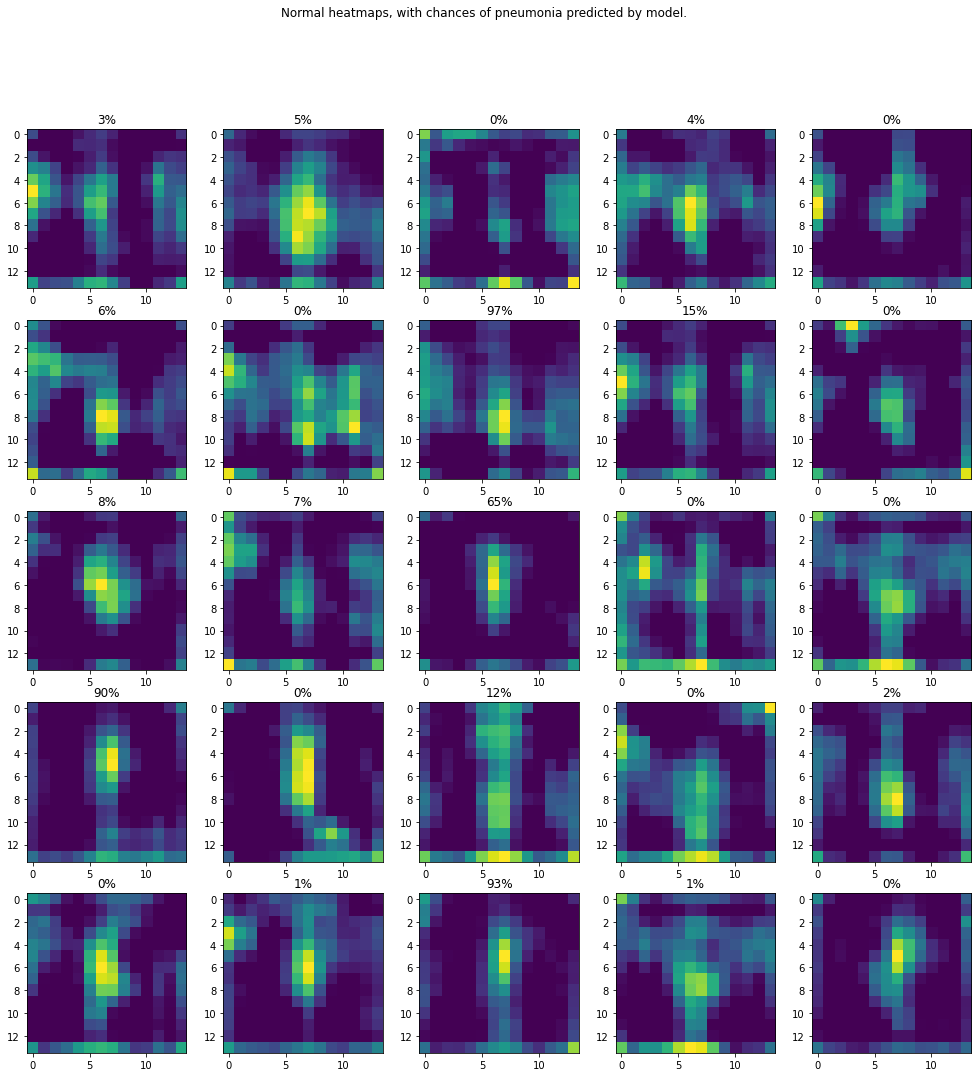

In [42]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool", "flatten", "dense"
]

heatmaps = []

for i in test_normal_sample_files:
  img_path = i
  img_array = get_img_array(img_path, size=(224,224))

  heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)
  heatmaps.append(heatmap)

heatgrid(heatmaps, normal_preds_array, "Normal heatmaps, with chances of pneumonia predicted by model.")

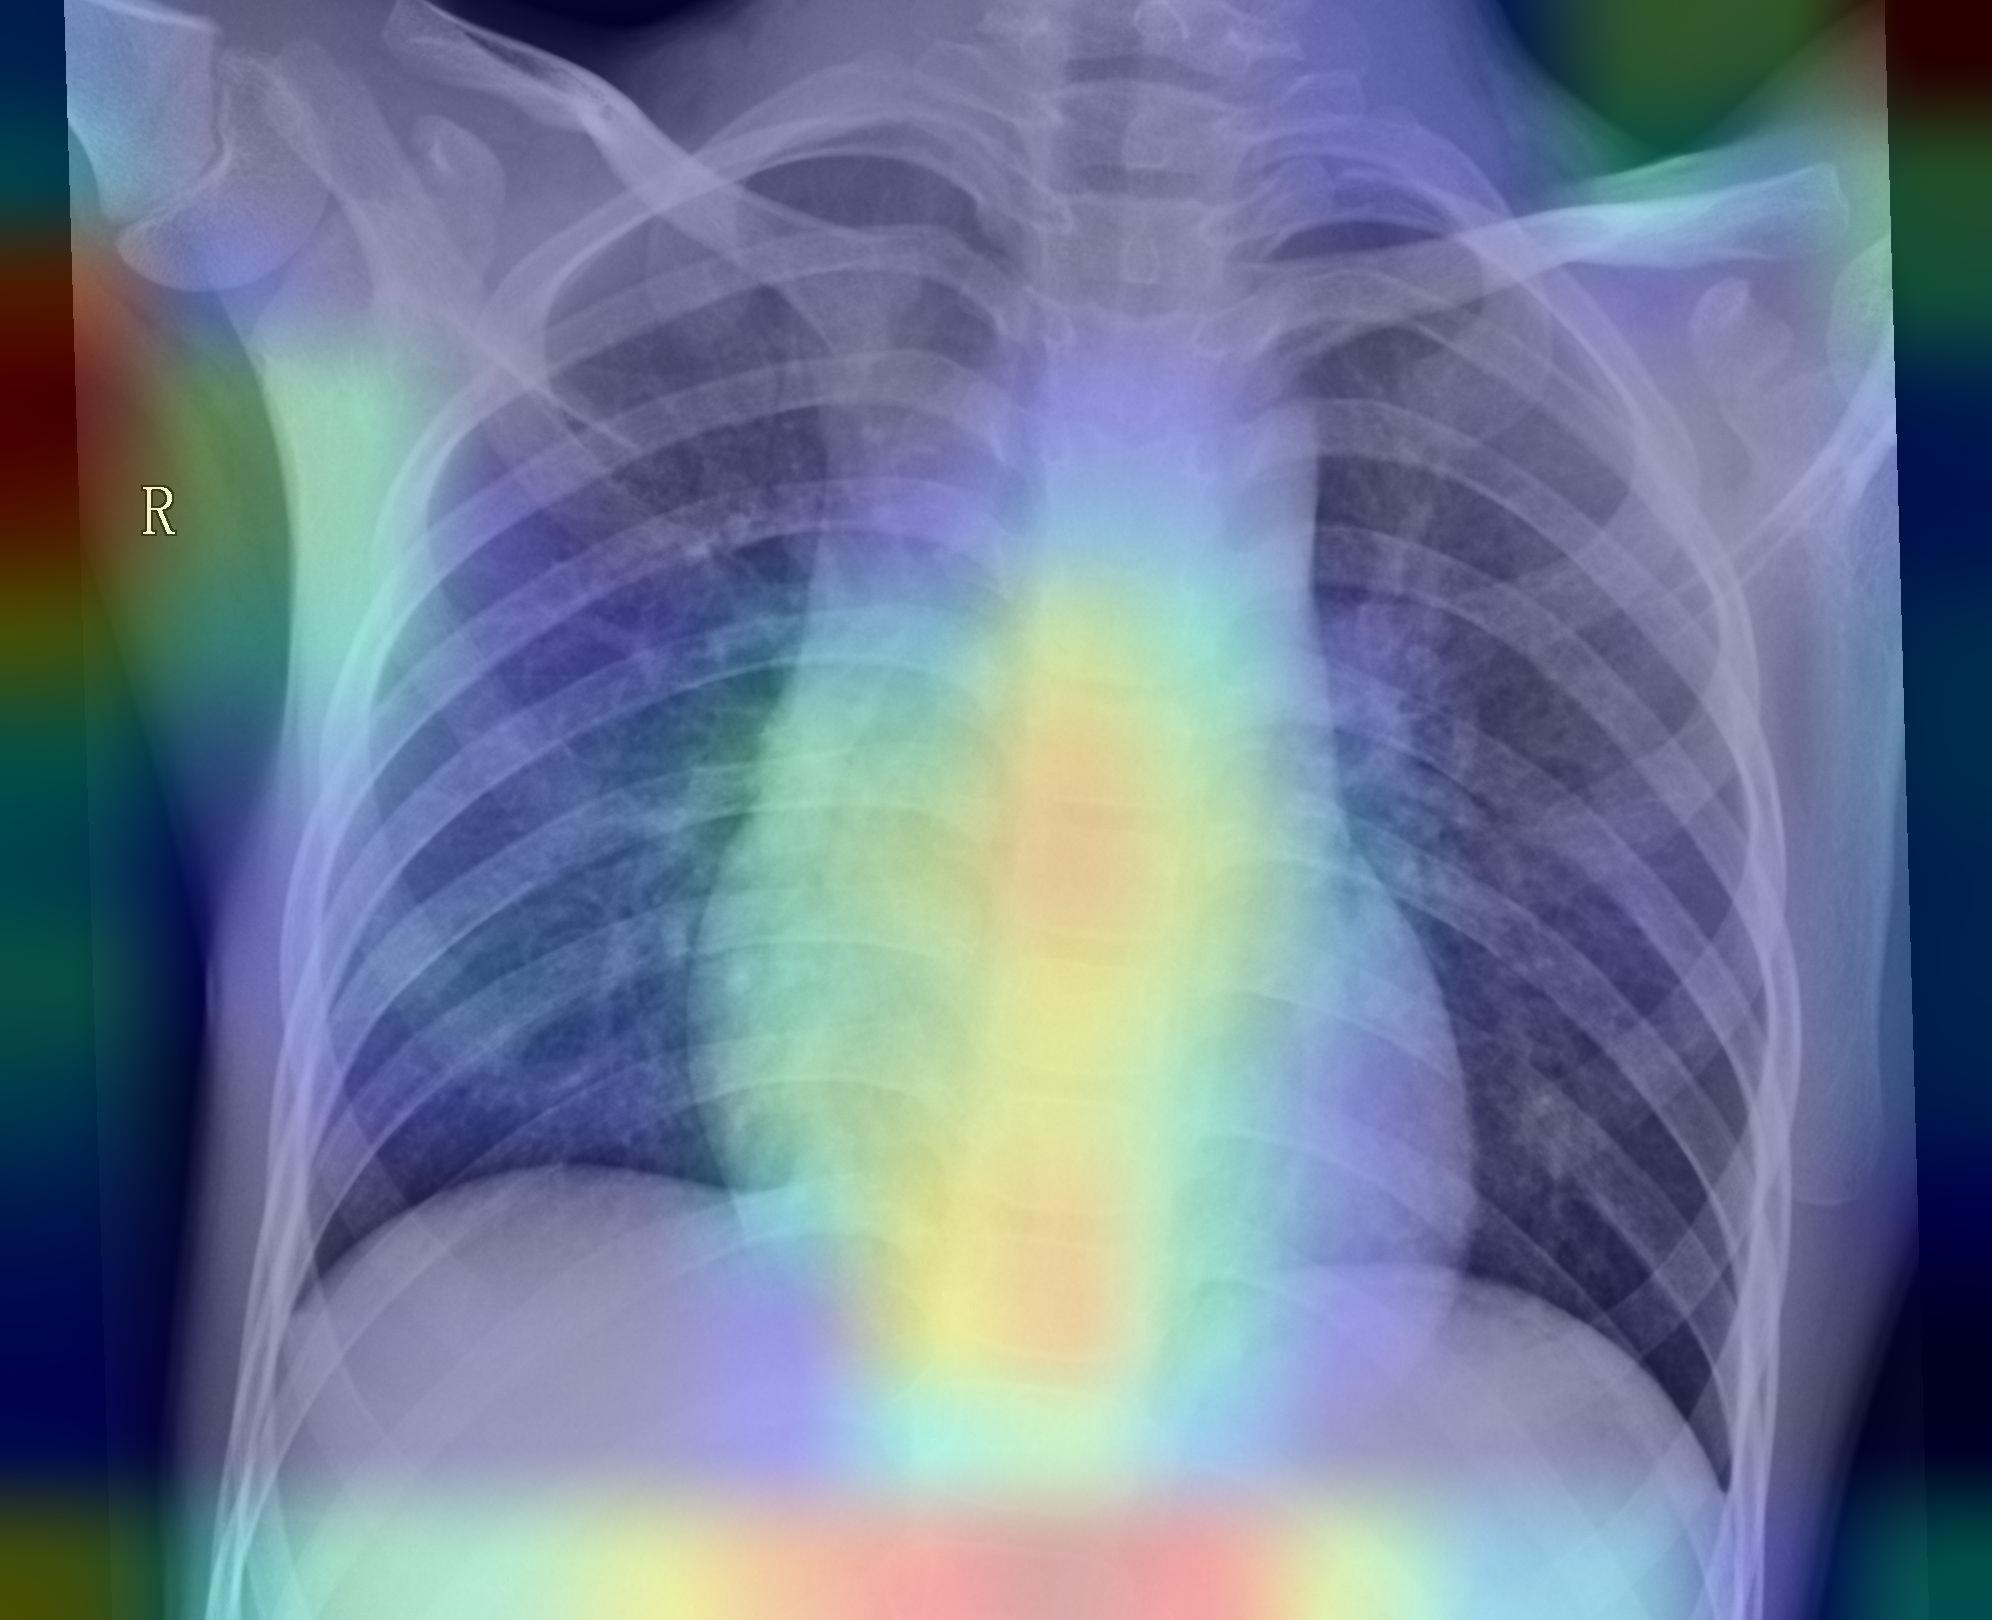

0.004593078978359699


In [43]:
superimposition(test_normal_sample_files[18], heatmaps[18])
print(normal_preds_array[18])

On the other hand, the model, when unsure if some case has pneumonia, does not focus much in one area of the lungs -- the model tends to be very diffuse.

# Three-way Classification

## Loading our data

In [44]:
# prepare three-way categorical data for training
%cd files/chest_xray/train
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
!ls

# prepare three-way categorical data for training
%cd ../test
!mkdir VIRUS
!mkdir BACTERIA
%cd PNEUMONIA
!bash -c 'mv *bacteria*.jpeg ../BACTERIA'
!bash -c 'mv *virus*.jpeg ../VIRUS'
%cd ..
!rmdir PNEUMONIA
%cd ../../..

/content/files/chest_xray/train
/content/files/chest_xray/train/PNEUMONIA
/content/files/chest_xray/train
BACTERIA  NORMAL  VIRUS
/content/files/chest_xray/test
/content/files/chest_xray/test/PNEUMONIA
/content/files/chest_xray/test
/content


In [45]:
def load_data_2(path, color_mode, size):

  imgs = []
  labels = []
  filenames = np.array([])

  for dir in ["NORMAL", "BACTERIA", "VIRUS"]:
    temp_path = path + "/" + dir
    counter = 0
    for f in os.listdir(temp_path):
      img = image.load_img(temp_path + "/" + f, color_mode=color_mode, target_size=size)
      x = image.img_to_array(img)
      imgs.append(x)

      labels.append([int(not ('bacteria' in f or 'virus' in f)), int('bacteria' in f), int('virus' in f)])

      filenames = np.append(filenames, temp_path + "/" + f)

      # to check progress:
      
      if (counter % 500 == 0):
        print("Files loaded for " + path + ": " + str(counter))
      counter += 1
   

  imgs = np.asarray(imgs)
  labels = np.asarray(labels)
  # normalize our data from values 0-1
  imgs /= 255
  print(imgs.shape) # left there for debug
  return imgs, labels, filenames

In [46]:
X_train, y_train, train_files = load_data_2("/content/files/chest_xray/train", "grayscale", (300,300))
X_test, y_test, test_files = load_data_2("/content/files/chest_xray/test", "grayscale", (300,300))

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
(5216, 300, 300, 1)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 300, 300, 1)


## Simple CNN

We will now test our three-way prediction capabilities with the same model as our previous sections, only this time, adapted to our

###oversampling

In [47]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

train viral pneumonia cases: 1345
train bacterial pneumonia cases: 2530
train normal cases: 1341


In [48]:
X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

print(normal_oversampling_indices)
print(viral_oversampling_indices)

[1126  860 1294 ...  312  758  442]
[ 327 1077  760 ...  385  404  245]


In [49]:
X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train_new = np.concatenate((X_train, X_train_concatenate_normal))
X_train_new = np.concatenate((X_train_new, X_train_concatenate_viral))


# new Y_train
y_train_new = np.concatenate((y_train, y_train_concatenate_normal))
y_train_new = np.concatenate((y_train_new, y_train_concatenate_viral))

print(X_train_new.shape)

(7530, 300, 300, 1)


In [50]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train_new])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train_new])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train_new])

print("train viral pneumonia cases: " + str(viral_indices.sum()))
print("train bacterial pneumonia cases: " + str(bacterial_indices.sum()))
print("train normal cases: " + str(normal_indices.sum()))

train viral pneumonia cases: 2500
train bacterial pneumonia cases: 2530
train normal cases: 2500


In [51]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))


model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        1

### training

In [52]:
traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train_new, y_train_new, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)

history = model.fit(gen_data,steps_per_epoch=len(gen_data),epochs=20,callbacks=callback,validation_data=gen_test,validation_steps=len(gen_test))

Epoch 1/20
236/236 [==============================] - 49s 204ms/step - loss: 1.0734 - accuracy: 0.4117 - val_loss: 0.9085 - val_accuracy: 0.6522
Epoch 2/20
236/236 [==============================] - 48s 205ms/step - loss: 0.8883 - accuracy: 0.5654 - val_loss: 0.8170 - val_accuracy: 0.7260
Epoch 3/20
236/236 [==============================] - 48s 205ms/step - loss: 0.8039 - accuracy: 0.6303 - val_loss: 0.8192 - val_accuracy: 0.7372
Epoch 4/20
236/236 [==============================] - 49s 208ms/step - loss: 0.7557 - accuracy: 0.6637 - val_loss: 0.7743 - val_accuracy: 0.6907
Epoch 5/20
236/236 [==============================] - 49s 207ms/step - loss: 0.7285 - accuracy: 0.6688 - val_loss: 0.8174 - val_accuracy: 0.7388


###diagnostics

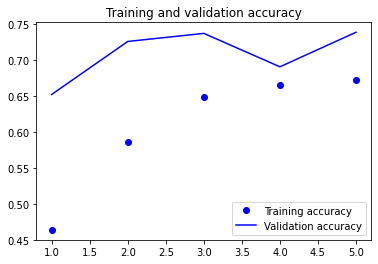

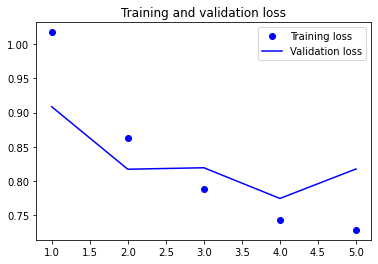

In [53]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

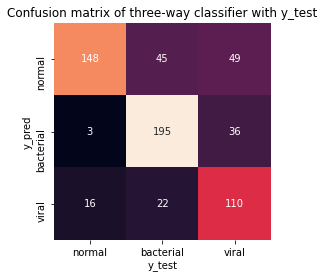

In [54]:
actual = y_test

pred_chances = np.empty((0,3), int)
preds = np.empty((0,3), int)

for i in test_files:
  img_path = i

  img = image.load_img(img_path, color_mode="grayscale", target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  pred_chance = model.predict(img)
  pred_chances = np.append(pred_chances, pred_chance, axis=0)

  pred = (pred_chance == pred_chance.max()).astype(int)
  preds = np.append(preds, pred, axis=0)


actual_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in actual]
pred_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in preds]

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(pred_labels, actual_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["normal","bacterial","viral"],
            yticklabels=["normal","bacterial","viral"])

plt.title('Confusion matrix of three-way classifier with y_test')
plt.xlabel('y_test')
plt.ylabel('y_pred');

##Simple CNN with Frozen Layers

In [55]:
np.random.seed(42)
tf.random.set_seed(42)


K.clear_session()

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1),trainable=False))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))


model.add(layers.Conv2D(64, (3, 3), activation='relu',trainable=False))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2),padding='same'))


model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3,activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        1

###training

In [56]:
traingen = ImageDataGenerator(
    rotation_range =45,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip = True
)

testgen = ImageDataGenerator()

gen_data = traingen.flow(X_train_new, y_train_new, batch_size=32)
gen_test = testgen.flow(X_test, y_test, batch_size=32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)

history = model.fit(gen_data,steps_per_epoch=len(gen_data),epochs=20,callbacks=callback,validation_data=gen_test,validation_steps=len(gen_test))

Epoch 1/20
236/236 [==============================] - 50s 210ms/step - loss: 1.0567 - accuracy: 0.4381 - val_loss: 1.0309 - val_accuracy: 0.5192
Epoch 2/20
236/236 [==============================] - 49s 206ms/step - loss: 0.8787 - accuracy: 0.6015 - val_loss: 0.8068 - val_accuracy: 0.7131
Epoch 3/20
236/236 [==============================] - 49s 206ms/step - loss: 0.8102 - accuracy: 0.6423 - val_loss: 0.8003 - val_accuracy: 0.7388
Epoch 4/20
236/236 [==============================] - 49s 206ms/step - loss: 0.7718 - accuracy: 0.6574 - val_loss: 0.6645 - val_accuracy: 0.7740
Epoch 5/20
236/236 [==============================] - 49s 208ms/step - loss: 0.7490 - accuracy: 0.6641 - val_loss: 0.6110 - val_accuracy: 0.7917
Epoch 6/20
236/236 [==============================] - 49s 207ms/step - loss: 0.7224 - accuracy: 0.6845 - val_loss: 0.7347 - val_accuracy: 0.6811
Epoch 7/20
236/236 [==============================] - 49s 207ms/step - loss: 0.7060 - accuracy: 0.6773 - val_loss: 0.6292 - val_ac

###diagnostics

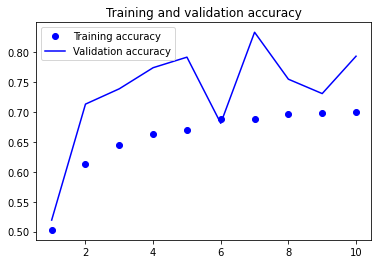

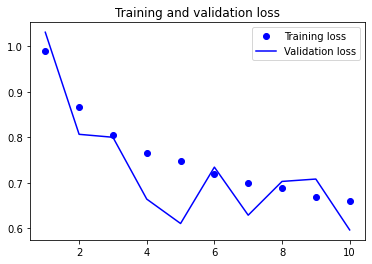

In [57]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

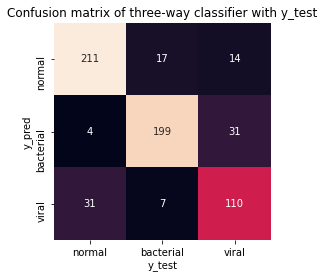

In [58]:
actual = y_test

pred_chances = np.empty((0,3), int)
preds = np.empty((0,3), int)

for i in test_files:
  img_path = i

  img = image.load_img(img_path, color_mode="grayscale", target_size=(300,300))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  pred_chance = model.predict(img)
  pred_chances = np.append(pred_chances, pred_chance, axis=0)

  pred = (pred_chance == pred_chance.max()).astype(int)
  preds = np.append(preds, pred, axis=0)


actual_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in actual]
pred_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in preds]

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(pred_labels, actual_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["normal","bacterial","viral"],
            yticklabels=["normal","bacterial","viral"])

plt.title('Confusion matrix of three-way classifier with y_test')
plt.xlabel('y_test')
plt.ylabel('y_pred');

## XCeption Transfer Learning

In [59]:
X_train, y_train, train_files = load_data_2("/content/files/chest_xray/train", "rgb", (150, 150))
X_test, y_test, test_files = load_data_2("/content/files/chest_xray/test", "rgb", (150, 150))

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
(5216, 150, 150, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 150, 150, 3)


In [60]:
np.random.seed(42)
tf.random.set_seed(42)

K.clear_session()

base_model = Xception(weights='imagenet',input_shape=(150, 150, 3),include_top=False)

base_model.trainable = False

x = Flatten()(base_model.output)

#add the number of classes we have to 
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

### training

In [61]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train])

X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train_new = np.concatenate((X_train, X_train_concatenate_normal))
X_train_new = np.concatenate((X_train_new, X_train_concatenate_viral))


# new Y_train
y_train_new = np.concatenate((y_train, y_train_concatenate_normal))
y_train_new = np.concatenate((y_train_new, y_train_concatenate_viral))

print(X_train_new.shape)

(7530, 150, 150, 3)


In [62]:
train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow(X_train_new, y_train_new, batch_size = 32)

test_set = test_datagen.flow(X_test, y_test, batch_size = 32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)

In [63]:
history = model.fit(training_set,steps_per_epoch=len(training_set),epochs=20,callbacks=callback,validation_data=test_set,validation_steps=len(test_set))

Epoch 1/20
236/236 [==============================] - 43s 170ms/step - loss: 6.0347 - accuracy: 0.6044 - val_loss: 2.1476 - val_accuracy: 0.7708
Epoch 2/20
236/236 [==============================] - 39s 165ms/step - loss: 4.3301 - accuracy: 0.6871 - val_loss: 3.7795 - val_accuracy: 0.6811
Epoch 3/20
236/236 [==============================] - 39s 164ms/step - loss: 3.9342 - accuracy: 0.7007 - val_loss: 4.5541 - val_accuracy: 0.7308
Epoch 4/20
236/236 [==============================] - 40s 167ms/step - loss: 3.7235 - accuracy: 0.7161 - val_loss: 3.8588 - val_accuracy: 0.6987


###diagnostics

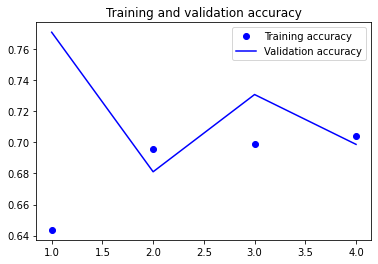

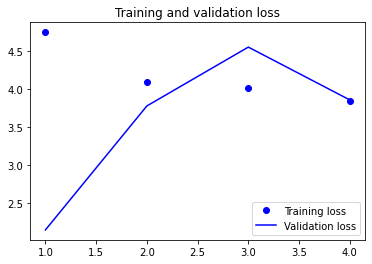

In [64]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

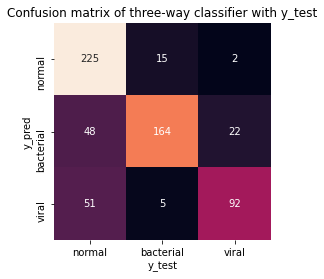

In [65]:
actual = y_test

pred_chances = np.empty((0,3), int)
preds = np.empty((0,3), int)

for i in test_files:
  img_path = i

  img = image.load_img(img_path, color_mode="rgb", target_size=(150,150))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  pred_chance = model.predict(img)
  pred_chances = np.append(pred_chances, pred_chance, axis=0)

  pred = (pred_chance == pred_chance.max()).astype(int)
  preds = np.append(preds, pred, axis=0)


actual_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in actual]
pred_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in preds]

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(pred_labels, actual_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["normal","bacterial","viral"],
            yticklabels=["normal","bacterial","viral"])

plt.title('Confusion matrix of three-way classifier with y_test')
plt.xlabel('y_test')
plt.ylabel('y_pred');

## VGG16 Transfer Learning

In [66]:
X_train, y_train, train_files = load_data_2("/content/files/chest_xray/train", "rgb", (224, 224))
X_test, y_test, test_files = load_data_2("/content/files/chest_xray/test", "rgb", (224, 224))

Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
Files loaded for /content/files/chest_xray/train: 1500
Files loaded for /content/files/chest_xray/train: 2000
Files loaded for /content/files/chest_xray/train: 2500
Files loaded for /content/files/chest_xray/train: 0
Files loaded for /content/files/chest_xray/train: 500
Files loaded for /content/files/chest_xray/train: 1000
(5216, 224, 224, 3)
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
Files loaded for /content/files/chest_xray/test: 0
(624, 224, 224, 3)


In [67]:
K.clear_session()

np.random.seed(42)
tf.random.set_seed(42)

img_size = [224,224]

train_path = "/content/files/chest_xray/train"
test_path = "/content/files/chest_xray/test"


vgg = VGG16(input_shape=img_size + [3], weights='imagenet', include_top=False)

vgg.trainable = False

x = Flatten()(vgg.output)

prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)



model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### training

In [68]:
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_train])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_train])
normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_train])

X_train_normals, y_train_normals = X_train[normal_indices], y_train[normal_indices]
X_train_viral, y_train_viral = X_train[viral_indices], y_train[viral_indices]

# this seed here is to maintain a deterministic runtime
np.random.seed(42)

normal_oversampling_indices = np.random.choice(X_train_normals.shape[0], 2500 - X_train_normals.shape[0])
viral_oversampling_indices = np.random.choice(X_train_viral.shape[0], 2500 - X_train_viral.shape[0])

X_train_concatenate_normal, y_train_concatenate_normal = X_train_normals[normal_oversampling_indices], y_train_normals[normal_oversampling_indices]
X_train_concatenate_viral, y_train_concatenate_viral = X_train_viral[viral_oversampling_indices], y_train_viral[viral_oversampling_indices]

# new X_train
X_train_new = np.concatenate((X_train, X_train_concatenate_normal))
X_train_new = np.concatenate((X_train_new, X_train_concatenate_viral))


# new Y_train
y_train_new = np.concatenate((y_train, y_train_concatenate_normal))
y_train_new = np.concatenate((y_train_new, y_train_concatenate_viral))

print(X_train_new.shape)

(7530, 224, 224, 3)


In [69]:
train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator()

training_set = train_datagen.flow(X_train_new, y_train_new, batch_size = 32)

test_set = test_datagen.flow(X_test, y_test, batch_size = 32)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.05,
    patience=3,
    mode="max",
    restore_best_weights=True,
)



In [70]:
history = model.fit(training_set,steps_per_epoch=len(training_set),epochs=20,callbacks=callback,validation_data=test_set,validation_steps=len(test_set))

Epoch 1/20
236/236 [==============================] - 83s 347ms/step - loss: 1.5475 - accuracy: 0.5848 - val_loss: 0.6583 - val_accuracy: 0.8125
Epoch 2/20
236/236 [==============================] - 82s 349ms/step - loss: 0.9443 - accuracy: 0.7125 - val_loss: 0.6488 - val_accuracy: 0.7885
Epoch 3/20
236/236 [==============================] - 82s 346ms/step - loss: 0.8901 - accuracy: 0.7293 - val_loss: 0.4490 - val_accuracy: 0.8702
Epoch 4/20
236/236 [==============================] - 82s 349ms/step - loss: 0.8454 - accuracy: 0.7492 - val_loss: 0.4652 - val_accuracy: 0.8894
Epoch 5/20
236/236 [==============================] - 83s 350ms/step - loss: 0.8004 - accuracy: 0.7515 - val_loss: 1.5062 - val_accuracy: 0.6635
Epoch 6/20
236/236 [==============================] - 82s 349ms/step - loss: 0.8013 - accuracy: 0.7595 - val_loss: 0.7258 - val_accuracy: 0.7660


###diagnostics

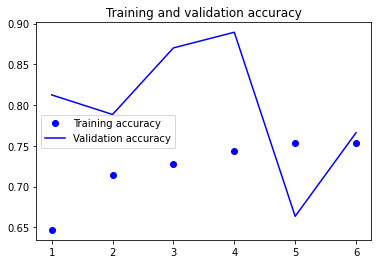

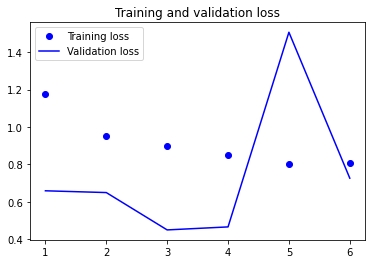

In [71]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

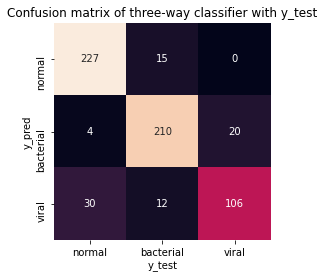

In [72]:
import seaborn as sns

actual = y_test

pred_chances = np.empty((0,3), int)
preds = np.empty((0,3), int)

for i in test_files:
  img_path = i

  img = image.load_img(img_path, color_mode="rgb", target_size=(224,224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x

  pred_chance = model.predict(img)
  pred_chances = np.append(pred_chances, pred_chance, axis=0)

  pred = (pred_chance == pred_chance.max()).astype(int)
  preds = np.append(preds, pred, axis=0)


actual_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in actual]
pred_labels = ["normal" if i[0] == 1 else "bacterial" if i[1] == 1 else "viral" for i in preds]

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(pred_labels, actual_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["normal","bacterial","viral"],
            yticklabels=["normal","bacterial","viral"])

plt.title('Confusion matrix of three-way classifier with y_test')
plt.xlabel('y_test')
plt.ylabel('y_pred');

## heatmaps, for our VGG-16 model


In [73]:
np.random.seed(42)

normal_indices = np.array([i[0] == 1 and i[1] == 0 and i[2] == 0 for i in y_test])
bacterial_indices = np.array([i[0] == 0 and i[1] == 1 and i[2] == 0 for i in y_test])
viral_indices = np.array([i[0] == 0 and i[1] == 0 and i[2] == 1 for i in y_test])
 
test_normal_files = test_files[normal_indices]
test_bacterial_files = test_files[bacterial_indices]
test_viral_files = test_files[viral_indices]

test_normal_sample_indices = np.random.choice(test_normal_files.shape[0], 25)
test_normal_sample_files = test_normal_files[test_normal_sample_indices]

test_bacterial_sample_indices = np.random.choice(test_bacterial_files.shape[0], 25)
test_bacterial_sample_files = test_bacterial_files[test_bacterial_sample_indices]

test_viral_sample_indices = np.random.choice(test_viral_files.shape[0], 25)
test_viral_sample_files = test_viral_files[test_viral_sample_indices]

In [74]:
normal_preds_array = np.array([])
normal_rounded = np.array([])
for i in test_normal_files:
  img_path = i

  # preds = model.predict(np.expand_dims(X_test[340], axis=0))

  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x
  # print(img)

  preds = model.predict(img)[0][0]
  normal_preds_array = np.append(normal_preds_array, preds)
  normal_rounded = np.append(normal_rounded, round(preds))

bacterial_preds_array = np.array([])
bacterial_rounded = np.array([])
for i in test_bacterial_files:
  img_path = i

  # preds = model.predict(np.expand_dims(X_test[340], axis=0))

  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x
  # print(img)

  preds = model.predict(img)[0][1]
  bacterial_preds_array = np.append(bacterial_preds_array, preds)
  bacterial_rounded = np.append(bacterial_rounded, round(preds))

viral_preds_array = np.array([])
viral_rounded = np.array([])
for i in test_viral_files:
  img_path = i

  # preds = model.predict(np.expand_dims(X_test[340], axis=0))

  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)
  img = x
  # print(img)

  preds = model.predict(img)[0][2]
  viral_preds_array = np.append(viral_preds_array, preds)
  viral_rounded = np.append(viral_rounded, round(preds))

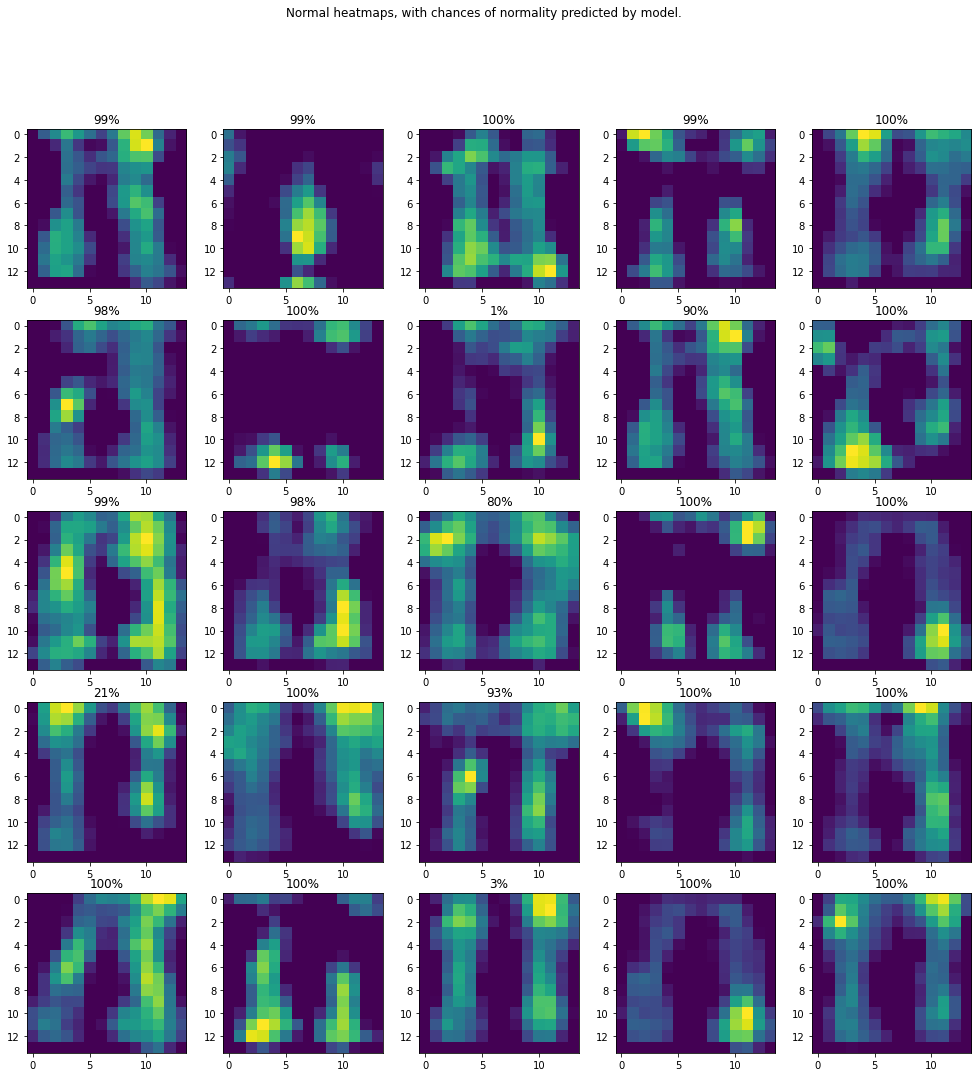

In [75]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool", "flatten", "dense"
]

heatmaps = []

for i in test_normal_sample_files:
  img_path = i
  img_array = get_img_array(img_path, size=(224,224))

  heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)
  heatmaps.append(heatmap)

heatgrid(heatmaps, normal_preds_array, "Normal heatmaps, with chances of normality predicted by model.")

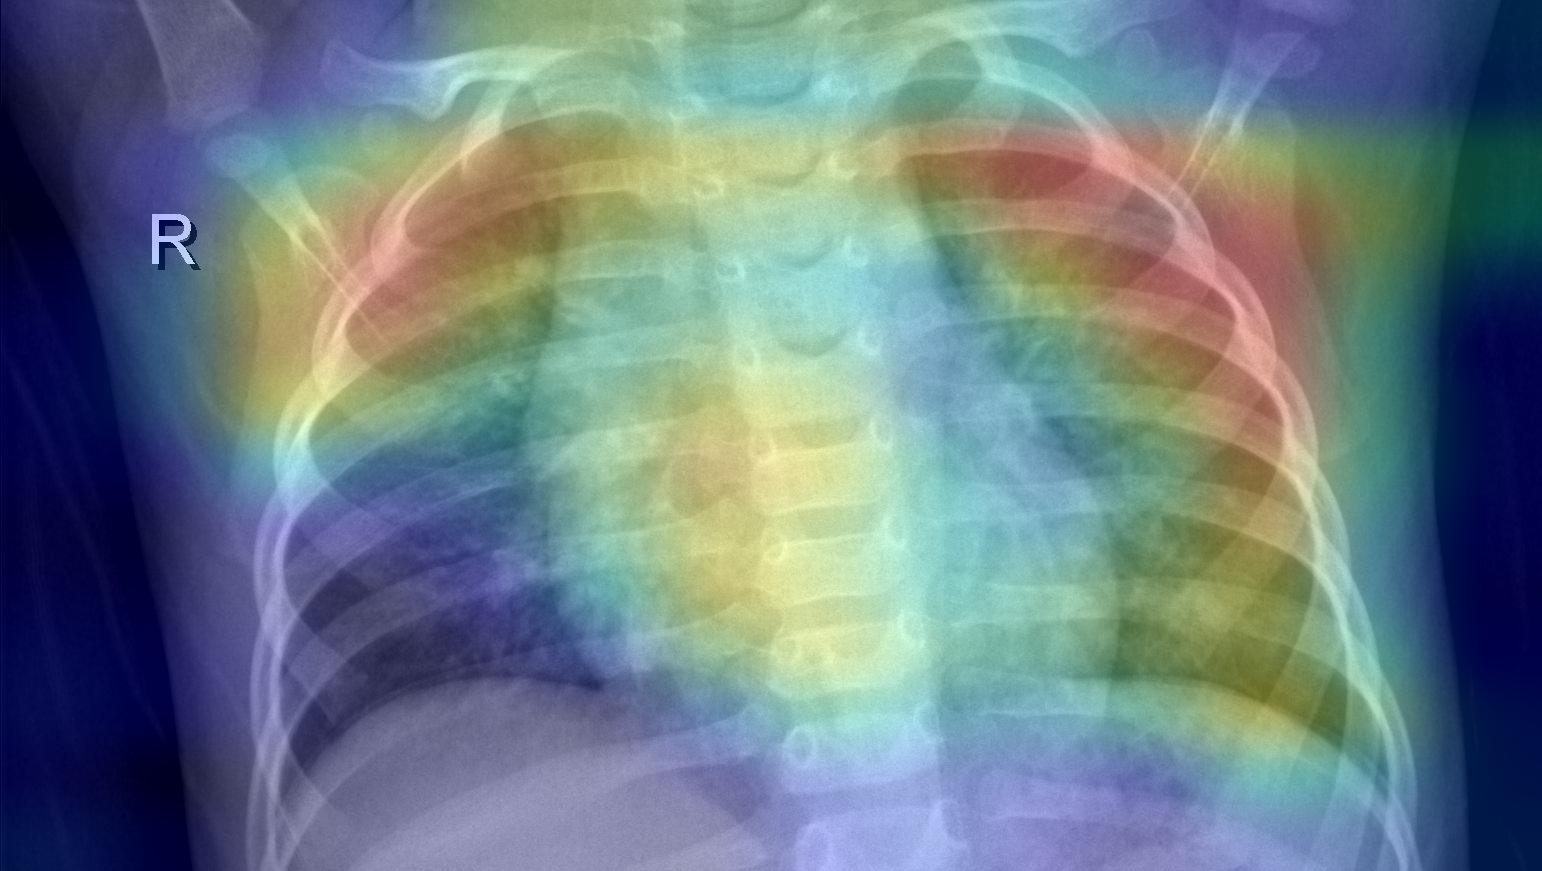

In [78]:
superimposition(test_normal_sample_files[6], heatmaps[6])

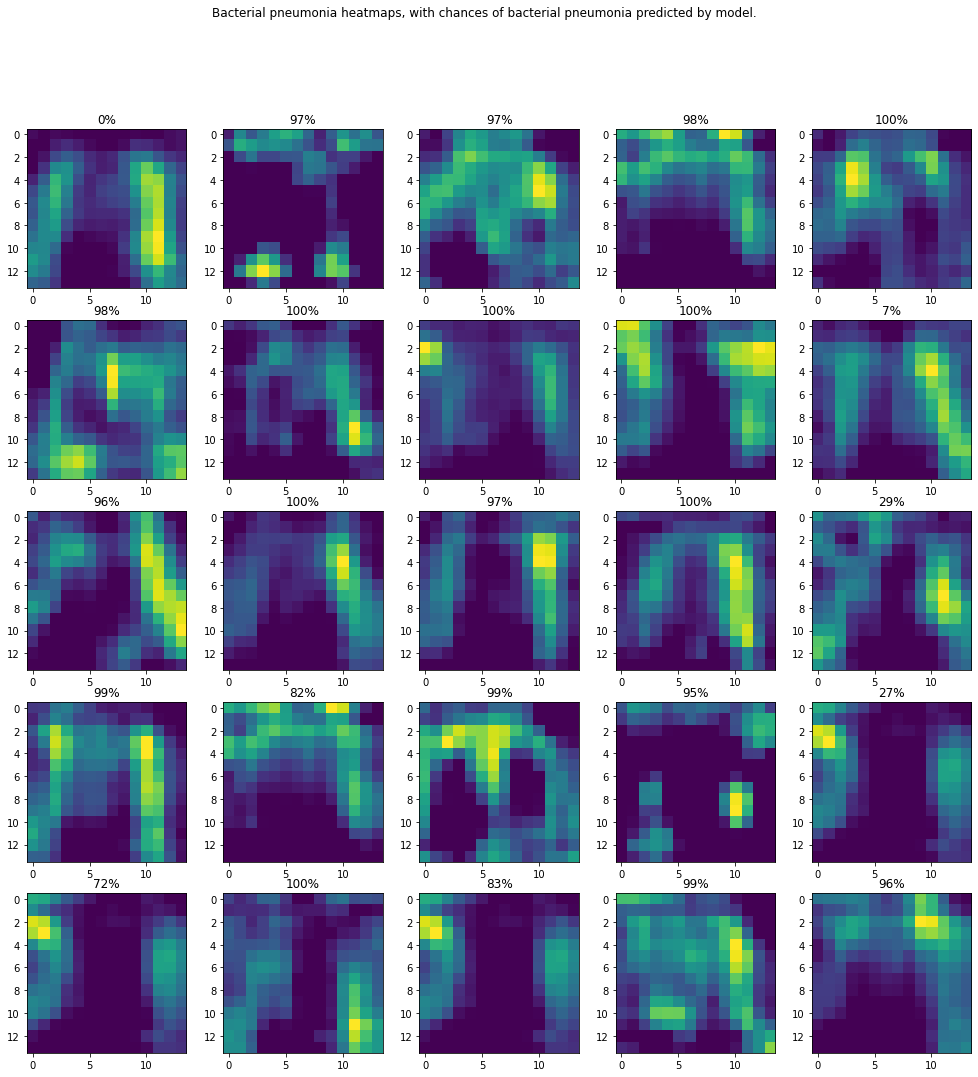

In [76]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool", "flatten", "dense"
]

heatmaps = []

for i in test_bacterial_sample_files:
  img_path = i
  img_array = get_img_array(img_path, size=(224,224))

  heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)
  heatmaps.append(heatmap)

heatgrid(heatmaps, bacterial_preds_array, "Bacterial pneumonia heatmaps, with chances of bacterial pneumonia predicted by model.")

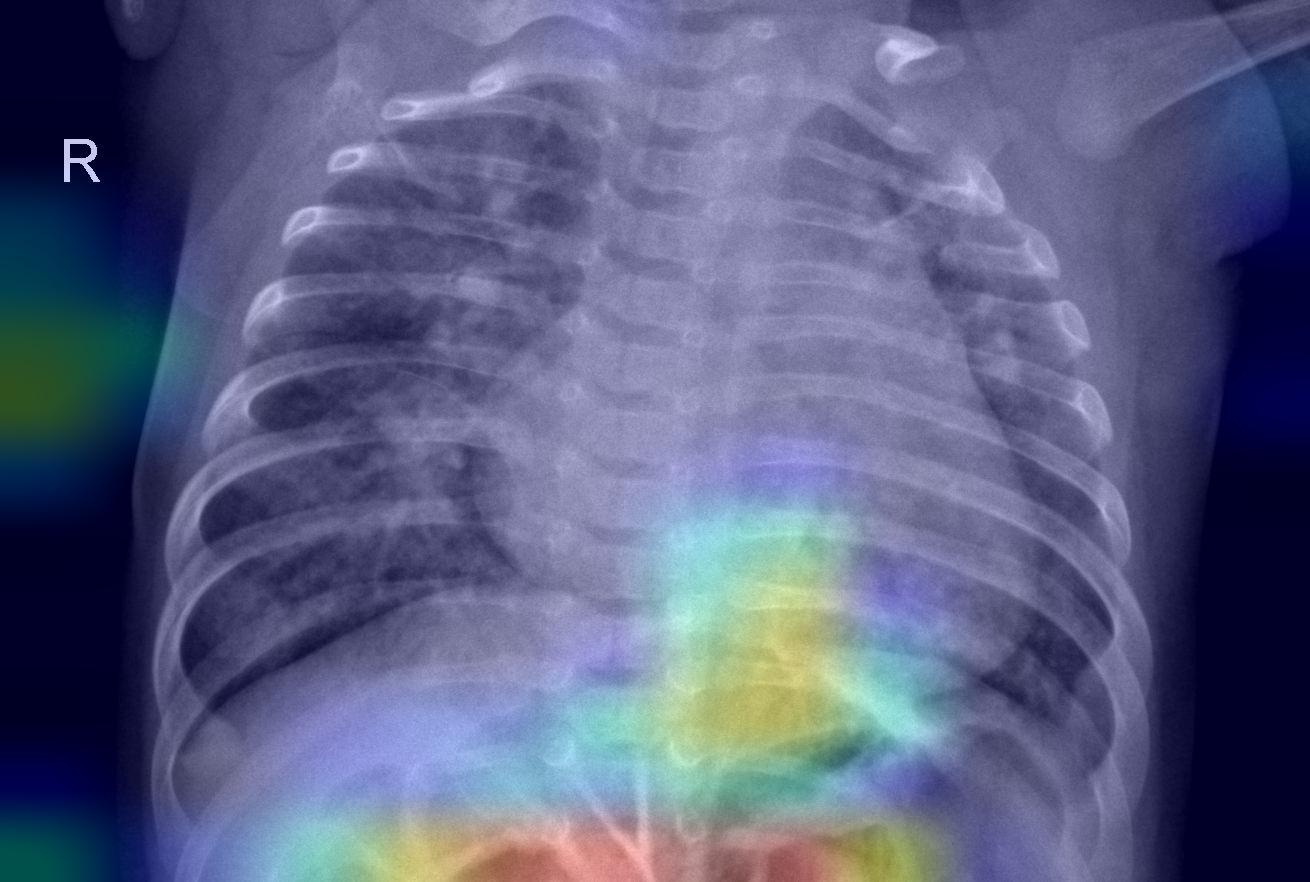

In [82]:
superimposition(test_bacterial_sample_files[17], heatmaps[17])

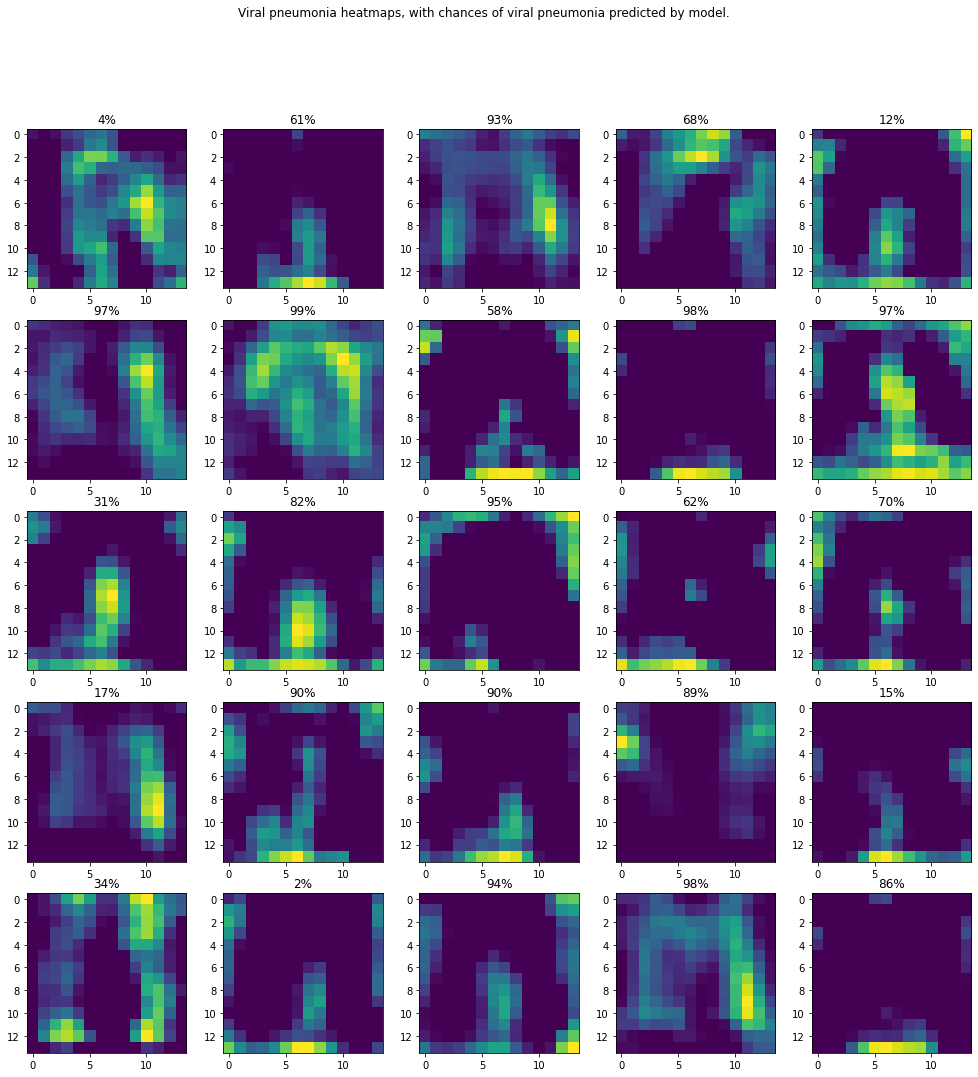

In [77]:
last_conv_layer_name = "block5_conv3"
classifier_layer_names = [
    "block5_pool", "flatten", "dense"
]
heatmaps = []

for i in test_viral_sample_files:
  img_path = i
  img_array = get_img_array(img_path, size=(224,224))

  heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names)
  heatmaps.append(heatmap)

heatgrid(heatmaps, viral_preds_array, "Viral pneumonia heatmaps, with chances of viral pneumonia predicted by model.")

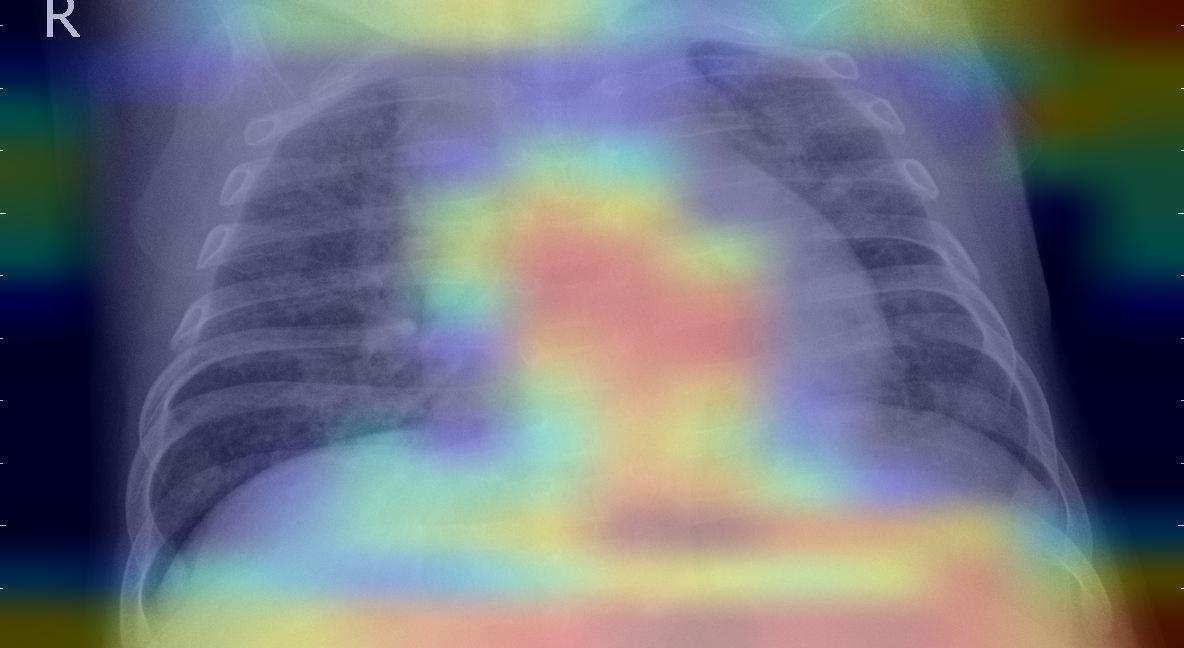

In [83]:
superimposition(test_viral_sample_files[9], heatmaps[9])

# Conclusions